In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torch.utils.data import random_split
import os
from tempfile import TemporaryDirectory

In [38]:
data_root = "datasets"

In [39]:
# for ResNet18:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [40]:
trainval_data = datasets.OxfordIIITPet(
        root=data_root,
        split='trainval',
        target_types='binary-category',
        transform=transform,
        download=False
    )
test_data = datasets.OxfordIIITPet(
        root=data_root,
        split='test',
        target_types='binary-category',
        transform=transform,
        download=False
    )

In [41]:
val_ratio = 0.2  # 20% for validation
train_size = int((1 - val_ratio) * len(trainval_data))
val_size = len(trainval_data) - train_size

train_data, val_data = random_split(trainval_data, [train_size, val_size])

In [42]:
len(val_data), len(train_data), len(test_data)

(736, 2944, 3669)

In [43]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [44]:
dataloaders = {}
dataset_sizes = {}

dataloaders['train'] = train_loader
dataloaders['val'] = val_loader
dataloaders['test'] = test_loader

dataset_sizes['train'] = len(train_data)
dataset_sizes['val'] = len(val_data)

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ResNet18
network = models.resnet18(weights='DEFAULT')
nf = network.fc.in_features
network.fc = nn.Linear(nf, 2)
network = network.to(device)

In [54]:
def train_network(network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=25):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    with TemporaryDirectory() as tempdir:
        best_network_params_path = os.path.join(tempdir, 'best_network_params.pt')

        torch.save(network.state_dict(), best_network_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    network.train()
                else:
                    network.eval()

                running_loss = 0.0
                running_corrects = 0

                for X, Y in dataloaders[phase]:
                    X = X.to(device)
                    Y = Y.to(device)

                    optimizer.zero_grad()

                    # forward
                    with torch.set_grad_enabled(phase == 'train'):
                        S = network(X)
                        _, P = torch.max(S, 1)
                        loss = criterion(S, Y)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * X.size(0)
                    running_corrects += torch.sum(P == Y.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc.item())
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc.item())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(network.state_dict(), best_network_params_path)

            print()

        print(f'Best val Acc: {best_acc:4f}')

        network.load_state_dict(torch.load(best_network_params_path, weights_only=True))
    return network, train_losses, val_losses, train_accuracies, val_accuracies

In [55]:
def compute_accuracy(network, loader, print_result=True):
    network.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X, Y in loader:
            X, Y = X.to(device), Y.to(device)
            S = network(X)
            _, P = torch.max(S, 1)
            correct += (P == Y).sum().item()
            total += Y.size(0)

    acc = 100 * correct / total
    if print_result:
        print(f"Test Accuracy: {acc:.2f}%")
    return acc

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=1e-4)

In [57]:
# Running for 25 epochs
network, train_losses, val_losses, train_accuracies, val_accuracies = train_network(
    network, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=25
)

Epoch 1/25
----------
train Loss: 0.0042 Acc: 0.9986
val Loss: 0.0478 Acc: 0.9823

Epoch 2/25
----------
train Loss: 0.0054 Acc: 0.9980
val Loss: 0.0629 Acc: 0.9783

Epoch 3/25
----------
train Loss: 0.0122 Acc: 0.9959
val Loss: 0.0736 Acc: 0.9783

Epoch 4/25
----------
train Loss: 0.0095 Acc: 0.9976
val Loss: 0.0795 Acc: 0.9755

Epoch 5/25
----------
train Loss: 0.0029 Acc: 0.9990
val Loss: 0.0473 Acc: 0.9837

Epoch 6/25
----------
train Loss: 0.0020 Acc: 0.9993
val Loss: 0.0521 Acc: 0.9851

Epoch 7/25
----------
train Loss: 0.0043 Acc: 0.9990
val Loss: 0.1158 Acc: 0.9728

Epoch 8/25
----------
train Loss: 0.0106 Acc: 0.9969
val Loss: 0.1197 Acc: 0.9715

Epoch 9/25
----------
train Loss: 0.0122 Acc: 0.9963
val Loss: 0.0496 Acc: 0.9851

Epoch 10/25
----------
train Loss: 0.0012 Acc: 0.9997
val Loss: 0.0395 Acc: 0.9864

Epoch 11/25
----------
train Loss: 0.0011 Acc: 1.0000
val Loss: 0.0344 Acc: 0.9878

Epoch 12/25
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.0354 Acc: 0.9891

E

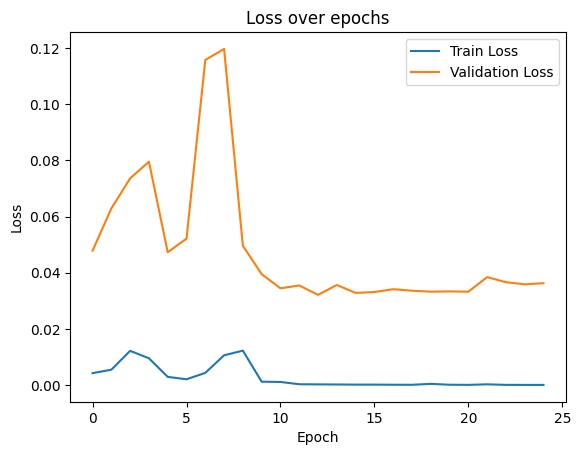

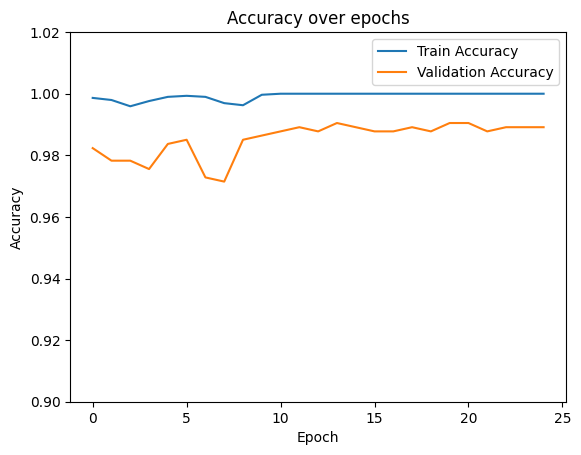

In [64]:
import matplotlib.pyplot as plt

plt.figure(facecolor='white')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.show()

plt.figure(facecolor='white')
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1.02])
plt.title('Accuracy over epochs')
plt.show()

In [59]:
compute_accuracy(network, test_loader)

Test Accuracy: 98.72%


98.71899700190788